# Principal Component Analysis (PCA) and Clustering Analysis (K-means) on Pain Charts

This is an example of the metholodogy used in the peer-reviewed article:

Boudreau, S.A., Royo, A.C., Matthews, M. et al. Distinct patterns of variation in the distribution of knee pain. Sci Rep 8, 16522 (2018). www.nature.com/articles/s41598-018-34950-2

Import of the libraries needed for preprocessing and analysis of the images

In [1]:
import pandas as pd
import sklearn
import cv2
import numpy as np
import skimage
import matplotlib.pyplot as plt
import glob
from PIL import Image
from sklearn.decomposition import PCA

In [2]:
# Let's import the file names from our dataset
fileNames = glob.glob(r'C:\Users\Albert\Documents\GitHub\PainCharts\data\*.png')
print('Number of files imported is',len(fileNames))

Number of files imported is 299


Pain charts are originally 3D images. However the interesting information from the images are the regions where the subjects has pain and not the background from the template. So this means that we are interested on pixes with (1) or without (0) pain. Therefore we will transform the images to a binary scale where pain (red) will be defined as 1 and the rest of the pixels as 0.

Pain charts from Navigate pain have several design errors that lead to problems when processed and manages. 
- The color painted is not a single value but a range of pixel colors which leads to have a wrong binarization if one does not have access to the painting algorithm used by the app - as it is the case.
- Images from different app version have diverse dimentions and characteristics.

Let's make a example of a binarization:

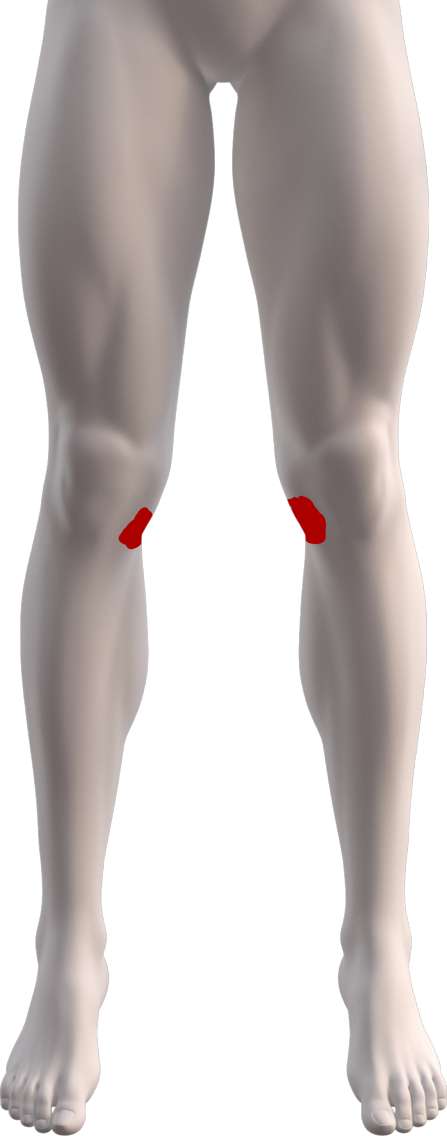

In [3]:
Image.open(fileNames[1])

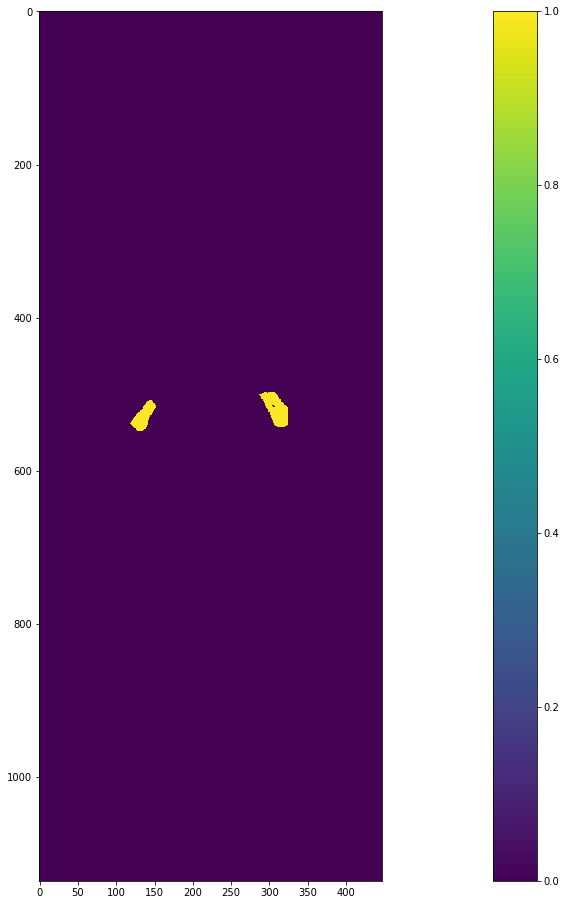

In [4]:
imExample = cv2.imread(fileNames[1])
binImExample = np.zeros(np.shape(imExample)[0:2])    
binImExample[(imExample[:,:,2]>150) & (imExample[:,:,0]==0)] = 1
plt.figure(figsize=(40,16))
plt.imshow(binImExample)
plt.colorbar()

As you can see in the image above there are some pixels which have been detected as painted regions but are actually artifacts.
Since this are small pixels, one can apply a morphological operation that can delete such artifacts.

An erosion and then a dilation, also known as opening the image.

A 3x3 kernel with cross-shaped values is not very invasive and appropiate for this case.

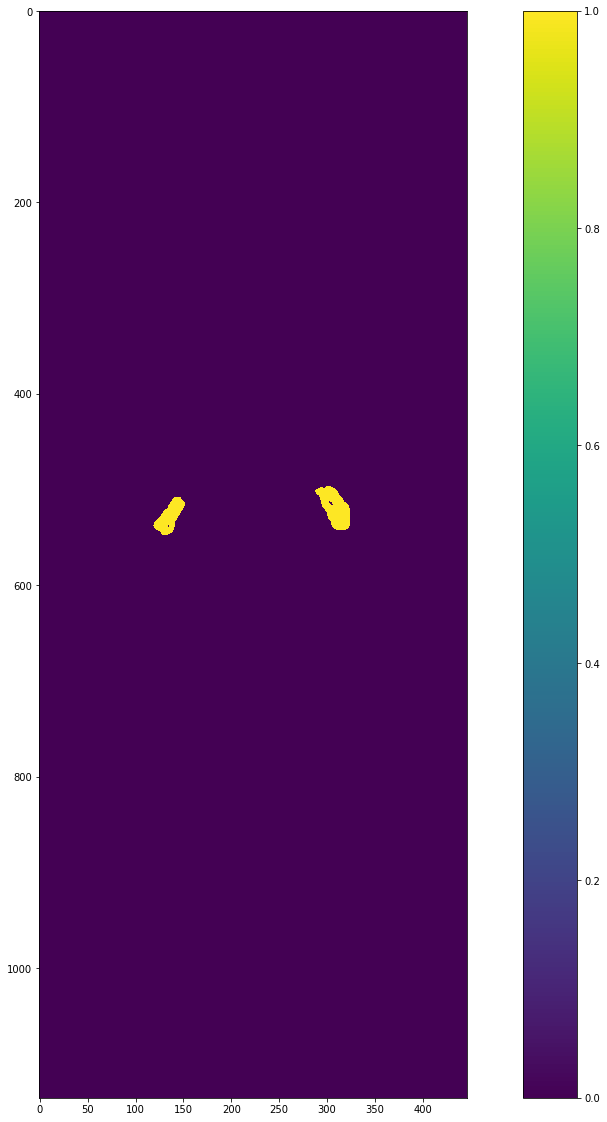

In [5]:
kernel = np.array([[0,1,0],[1,1,1],[0,1,0]],np.uint8)
opening = cv2.morphologyEx(binImExample, cv2.MORPH_OPEN, kernel)
plt.figure(figsize=(20,20))
plt.imshow(opening)
plt.colorbar()

As we can see on top, the artifacts are gone and the morphology of the pain region has been almost unchanged.

Let's load all the images and preprocess them before the PCA analysis

In [6]:
kernel = np.array([[0,1,0],[1,1,1],[0,1,0]],np.uint8)
binIms = []
imListVect = pd.DataFrame([])   
i = 0
PainChartList = []
LabelList = []
for fileName in fileNames:
    im = cv2.imread(fileName)
    binIm = np.zeros(np.shape(im)[0:2])
    #Creating a mask from the pain Image, this will be the binarized version of the image
    binIm[(im[:,:,2]>150) & (im[:,:,0]==0)] = 1
    #Open the pain region so small empty spaces within the pain region are filled
    binIm = cv2.morphologyEx(binIm, cv2.MORPH_OPEN, kernel)
    #Saving images and names (labels) in a List 
    PainChartList.append(binIm)
    LabelList.append(fileName)
    #Preparing the images for a PCA
    binImS = pd.Series(binIm.flatten(),name=fileName)
    imListVect = imListVect.append(binImS)

In [7]:
imListVect.shape

(299, 507792)

Now that we have the vectorized images in a List we can put them in the PC

In [8]:
pca = PCA()
pca.fit(imListVect)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [9]:
explainedVariance = pd.DataFrame(pca.explained_variance_ratio_,columns = ['Explained variance'])    
explainedVariance.head(20).round(4)*100

,Explained variance
0,14.72
1,7.74
2,6.14
3,5.13
4,3.48
5,3.24
6,2.70
7,2.12
8,1.97
9,1.72


PC selection is tricky. One can define a threshold of explained information or since we are working with images we can visualize them. In this case we will define a 5% of explained information as threshold and therefore we will visualize the first 5 PC.

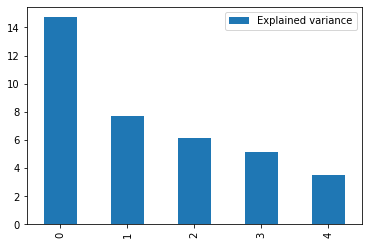

In [10]:
explained5 = explainedVariance[0:5].round(4)*100;

explained5.plot(kind='bar')


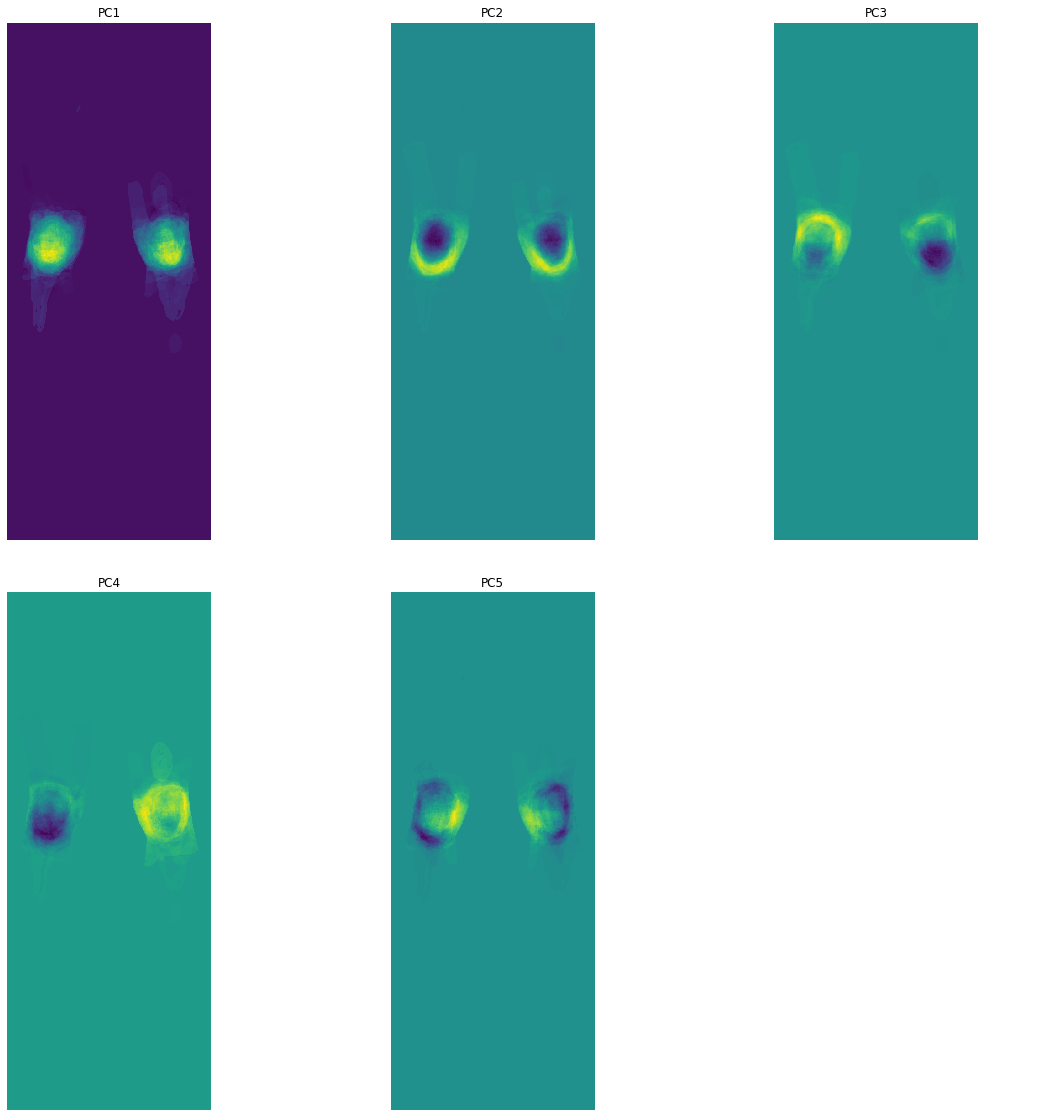

In [11]:
#function plotting several images in a subplot
def multiplePlot(data,title):
    if np.size(data,0)<=3:
        numX = 1
        numY = np.size(data,0)
    else:
        numX = int(np.ceil(np.size(data,0)/3))
        numY = 3
    fig, axes = plt.subplots(numX,numY, figsize=(20, 20),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        if i<np.size(data,0):
            ax.set_title(title+'%s'%(i+1))
            ax.imshow(data[i].reshape(np.shape(im)[0:2]))
        ax.axis('off')
multiplePlot(pca.components_[0:5,],"PC")

Now we can have an idea of how look the different PC. Following the paper from Boudreu we will chose 3 PC as features for the clustering analysis. In this case we will use K-means.

In order to know the best K we can produce a ROC curve with the inter cluster distance and select the number of cluster that lays on the elbow of the ROC curve.

Let's proceed.

In [33]:
kmeans = []
interDistance = []
#first we need to calculate the coefficients/weights for each image
imNewFeat = pca.transform(imListVect)
from sklearn.cluster import k_means
for i in range(2,10):
    kmean = k_means(imNewFeat[:,0:5],n_clusters = i)
    kmeans.append(kmean)
    interDistance.append(kmean[2])

Let's produces the ROC curve for the inter distance

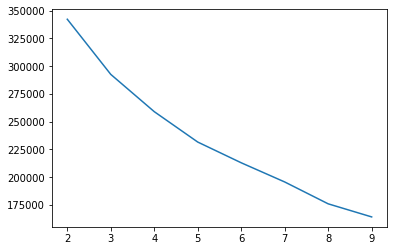

In [34]:
plt.plot(range(2,10),interDistance)

Seems that's 4 cluster would be the most adequate K

Note: Theoretically this curve should look more like a invese exponential

In [82]:
#Saving results
np.savetxt('classesK4',kmeans[2][1])

From this we can find one big cluster with other 3 smaller

How can we visualize the cluster? We can create a heatmap to find the pain morphology for each group.

In [76]:
indG1 = np.where(kmeans[2][1] == 0)
indG2 = np.where(kmeans[2][1] == 1)
indG3 = np.where(kmeans[2][1] == 2)
indG4 = np.where(kmeans[2][1] == 3)

In [79]:
imListG1 = imListVect.iloc[indG1].to_numpy()
imListG2 = imListVect.iloc[indG2].to_numpy()
imListG3 = imListVect.iloc[indG3].to_numpy()
imListG4 = imListVect.iloc[indG4].to_numpy()
imListClusters = [imListG1,imListG2,imListG3,imListG4]

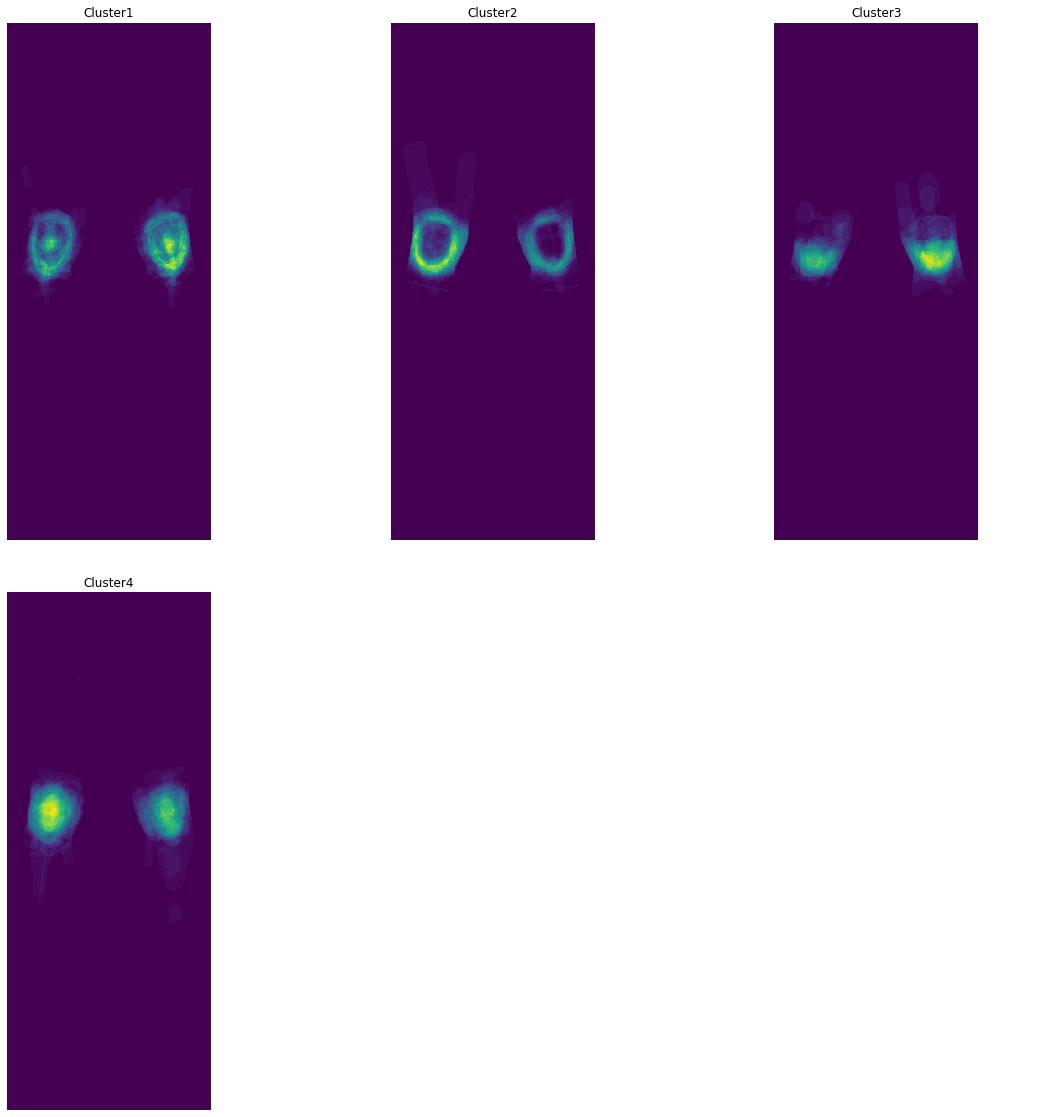

In [80]:
def overlayHotMap(imList,size):
    imListReshaped = imList.sum(axis=0).reshape(size)
    return imListReshaped
Overlays = []
for clust in imListClusters:
    overlayClust = overlayHotMap(clust,np.shape(im)[0:2])
    Overlays.append(overlayClust)   

multiplePlot(Overlays,'Cluster')